## Enhanced KMeans with Interaction Analysis

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Union
import logging
from itertools import combinations
import networkx as nx

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, euclidean
from scipy.signal import savgol_filter
from scipy.stats import zscore, pearsonr
from scipy.ndimage import gaussian_filter1d

import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

/home/liubov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
joint_positions =  pd.read_csv("joint_positions.csv")
joint_positions

,Unnamed: 0.1,Unnamed: 0,Patient,Joint,Frame,X,Y
0,0,0,Patient_1,Nose,5,436.66135,76.533104
1,1,1,Patient_1,Nose,6,436.66068,76.558914
2,2,2,Patient_1,Nose,7,436.50210,78.160120
3,3,3,Patient_1,Nose,8,436.44742,78.432010
4,4,4,Patient_1,Nose,9,436.44205,78.703476
...,...,...,...,...,...,...,...
257240,257240,257240,Therapist_2,Background,11736,595.59110,318.607760
257241,257241,257241,Therapist_2,Background,11737,598.25140,317.726930
257242,257242,257242,Therapist_2,Background,11738,582.33325,308.531160
257243,257243,257243,Therapist_2,Background,11739,583.90326,306.941250


### Attention on therapist (from gaze angle)

In [20]:
joint_positions =  pd.read_csv("joint_positions.csv")

# Pivot for child joints (assuming 'Patient' == 'Patient_1' etc. are children)
joint_positions.reset_index(inplace=True)
child_df = joint_positions[joint_positions['Patient'].str.contains('Patient')]

child_pivot = child_df.pivot_table(index=['Patient', 'Frame'], 
                                   columns='Joint', 
                                   values=['X', 'Y']).reset_index()

# Flatten multi-index columns
child_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in child_pivot.columns.values]

# Pivot for therapist joints
therapist_df = joint_positions[joint_positions['Patient'].str.contains('Therapist')]

therapist_pivot = therapist_df.pivot_table(index=['Patient', 'Frame'], 
                                           columns='Joint', 
                                           values=['X', 'Y']).reset_index()

therapist_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in therapist_pivot.columns.values]

# Select therapist wrist positions (assuming single therapist or pick one)
therapist_wrist = therapist_pivot[['Frame', 'Patient', 'X_RWrist', 'Y_RWrist']].rename(
    columns={'X_RWrist': 'X_TherapistWrist', 'Y_RWrist': 'Y_TherapistWrist', 'Patient': 'Therapist'})


# Merge therapist wrist positions into child data by Frame (inner join)
merged_df = child_pivot.merge(therapist_wrist[['Frame', 'X_TherapistWrist', 'Y_TherapistWrist']], 
                              left_on='Frame', right_on='Frame', how='left')


# Calculate gaze vectors and angles similarly on merged_df...
merged_df['X_EyesMid'] = (merged_df['X_REye'] + merged_df['X_LEye']) / 2
merged_df['Y_EyesMid'] = (merged_df['Y_REye'] + merged_df['Y_LEye']) / 2

merged_df['gaze_vec_x'] = merged_df['X_EyesMid'] - merged_df['X_Nose']
merged_df['gaze_vec_y'] = merged_df['Y_EyesMid'] - merged_df['Y_Nose']

# Vector from nose to child's right wrist
merged_df['vec_nose_to_childWrist_x'] = merged_df['X_RWrist'] - merged_df['X_Nose']
merged_df['vec_nose_to_childWrist_y'] = merged_df['Y_RWrist'] - merged_df['Y_Nose']

# Vector from nose to therapist's wrist
merged_df['vec_nose_to_therapistWrist_x'] = merged_df['X_TherapistWrist'] - merged_df['X_Nose']
merged_df['vec_nose_to_therapistWrist_y'] = merged_df['Y_TherapistWrist'] - merged_df['Y_Nose']

In [28]:
def calculate_angle(row, vec_x, vec_y):
    a_x, a_y = row['gaze_vec_x'], row['gaze_vec_y']
    b_x, b_y = row[vec_x], row[vec_y]
    
    dot_product = a_x * b_x + a_y * b_y
    norm_a = np.sqrt(a_x**2 + a_y**2)
    norm_b = np.sqrt(b_x**2 + b_y**2)
    
    # Avoid division by zero
    if norm_a == 0 or norm_b == 0:
        return np.nan
    
    cos_theta = dot_product / (norm_a * norm_b)
    # Clip to valid range due to floating point errors
    cos_theta = np.clip(cos_theta, -1, 1)
    
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

merged_df['angle_to_childWrist'] = merged_df.apply(calculate_angle, axis=1,
                                                  vec_x='vec_nose_to_childWrist_x', vec_y='vec_nose_to_childWrist_y')

merged_df['angle_to_therapistWrist'] = merged_df.apply(calculate_angle, axis=1,
                                                      vec_x='vec_nose_to_therapistWrist_x', vec_y='vec_nose_to_therapistWrist_y')


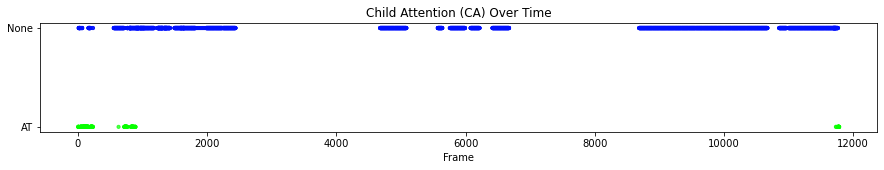

In [45]:
# Define threshold (degrees)
threshold = 60

# Initialize CA column as None or 'None'
merged_df['CA'] = 'None'

# Classify attention
merged_df.loc[merged_df['angle_to_childWrist'] < threshold, 'CA'] = 'AO'  # Attention on objects (child's hand)
merged_df.loc[merged_df['angle_to_therapistWrist'] < threshold, 'CA'] = 'AT'  # Attention on therapist

# If both angles are below threshold, prioritize therapist attention (or choose your logic)
merged_df.loc[(merged_df['angle_to_childWrist'] < threshold) & 
              (merged_df['angle_to_therapistWrist'] < threshold), 'CA'] = 'AT'

# Get unique categories from CA
categories = merged_df['CA'].unique()

# Generate a color palette with seaborn for all categories
palette = sns.color_palette("hsv", len(categories))
color_map = dict(zip(categories, palette))

# Map colors for plotting
colors = merged_df['CA'].map(color_map)

plt.figure(figsize=(15, 2))
plt.scatter(merged_df['Frame'], merged_df['CA'], c=colors, s=10, alpha=0.7)

plt.title('Child Attention (CA) Over Time')
plt.xlabel('Frame')
plt.yticks(categories)
plt.show()
# CAT (child attention on therapist): AT (attention on therapists)

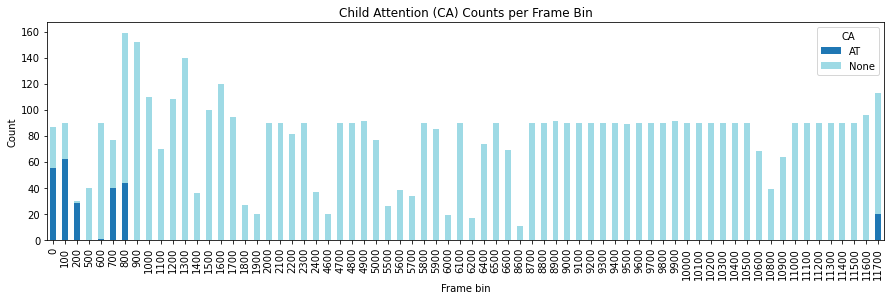

In [44]:
# Define bin size
bin_size = 100

# Create bins
merged_df['Frame_bin'] = (merged_df['Frame'] // bin_size) * bin_size

# Count categories per bin
counts = merged_df.groupby(['Frame_bin', 'CA']).size().unstack(fill_value=0)

# Plot stacked bar chart
counts.plot(kind='bar', stacked=True, figsize=(15, 4), colormap='tab20')

plt.title('Child Attention (CA) Counts per Frame Bin')
plt.xlabel('Frame bin')
plt.ylabel('Count')
plt.show()


1. More Detailed Interaction Analysis

Combine CA with child position (CP) or gaze (CG) to see when and how attention changes depending on posture or gaze direction.

For example: Does attention on therapist (AT) happen more when the child is sitting (CSI) or standing (CST)?

2. Detect Joint Attention Events

Look for simultaneous attention between child and therapist (joint eye contact).

Identify moments where both focus on the same object area (e.g., therapist’s hand and child’s hand proximity).

3. Temporal Patterns and Transitions

Analyze how child attention shifts over time — e.g., does attention on therapist increase after certain events or at specific times?

Use transition matrices to study probabilities of switching between attention states (None → AT and vice versa).

4. Predictive Modeling

Use joint positions and past attention states to predict future child attention.

Could apply simple models like logistic regression or more advanced like LSTM neural networks (sequence models).

5. Add Voice or Interaction Data

If you have voice or interaction labels (CS, TS, etc.), combine them to study correlations between attention and vocalizations.

6. Clustering and Profiling

Cluster frames or segments into behavioral profiles (e.g., “high attention,” “low attention,” “mixed”) to categorize interaction styles.

In [49]:
pose_classification = pd.read_csv("pose_classification.csv")
pose_classification.drop("Unnamed: 0", axis=1, inplace=True)

In [54]:
# Merge with pose_classification
combined_df = merged_df.merge(pose_classification[['Patient', 'Frame', 'Pose']],
                              on=['Patient', 'Frame'], how='left')

attention_by_pose = combined_df.groupby('Pose')['CA'].value_counts(normalize=True).unstack().fillna(0)
print(attention_by_pose)

CA              AT      None
Pose                        
Sitting   0.000000  1.000000
Standing  0.044851  0.955149


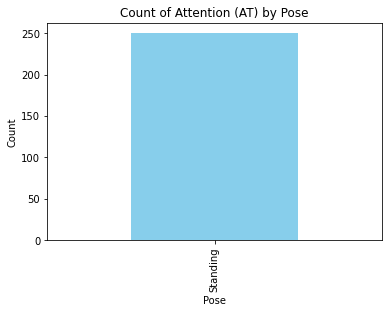

In [55]:
attention_counts = combined_df[combined_df['CA'] == 'AT'].groupby('Pose').size()

attention_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Attention (AT) by Pose')
plt.ylabel('Count')
plt.show()


In [56]:
# Map poses to numeric codes
pose_codes = {pose: i for i, pose in enumerate(combined_df['Pose'].unique())}
combined_df['Pose_code'] = combined_df['Pose'].map(pose_codes)


{'Standing': 0, 'Sitting': 1}


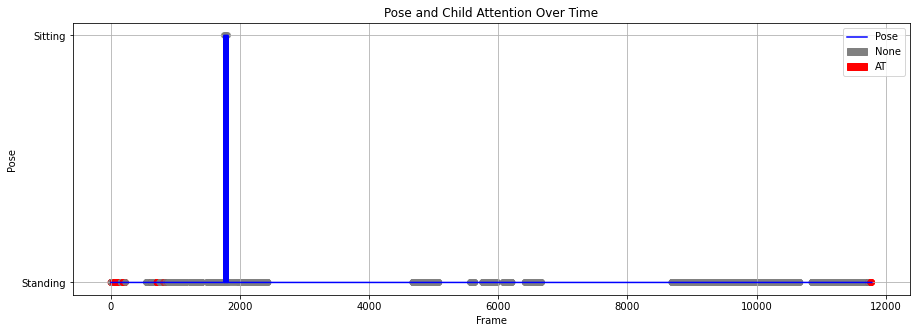

In [64]:
plt.figure(figsize=(15, 5))

# Plot Pose as a line
plt.plot(combined_df['Frame'].to_numpy(), combined_df['Pose_code'].to_numpy(), label='Pose', color='blue')

# Overlay Attention as colored dots
attention_colors = {'None': 'gray', 'AT': 'red'}
scatter = plt.scatter(combined_df['Frame'], combined_df['Pose_code'],
                      c=combined_df['CA'].map(attention_colors),
                      label='Child Attention (CA)', s=30, alpha=0.7)

# Add labels for Pose ticks
plt.yticks(list(pose_codes.values()), list(pose_codes.keys()))

plt.xlabel('Frame')
plt.ylabel('Pose')
plt.title('Pose and Child Attention Over Time')
plt.grid(True)

# Create custom legend for attention colors
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in attention_colors.items()]
plt.legend(handles=[plt.Line2D([0], [0], color='blue', label='Pose')] + legend_patches)

plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import networkx as nx
from itertools import combinations
from typing import Dict, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

class ImprovedPoseFeatureExtractor:
    """Extract pose features and interaction metrics from joint positions"""
    
    def __init__(self):
        # Define joint relationships for angle calculations
        self.joint_pairs = {
            'left_arm_angle': ['LeftShoulder', 'LeftElbow', 'LeftWrist'],
            'right_arm_angle': ['RightShoulder', 'RightElbow', 'RightWrist'],
            'left_leg_angle': ['LeftHip', 'LeftKnee', 'LeftAnkle'],
            'right_leg_angle': ['RightHip', 'RightKnee', 'RightAnkle'],
            'torso_angle': ['Neck', 'MidHip'],
        }
        
        # Define distance measurements
        self.distance_pairs = {
            'shoulder_width': ['LeftShoulder', 'RightShoulder'],
            'hip_width': ['LeftHip', 'RightHip'],
            'torso_length': ['Neck', 'MidHip'],
            'left_arm_length': ['LeftShoulder', 'LeftWrist'],
            'right_arm_length': ['RightShoulder', 'RightWrist'],
        }
        
        # Key points for interaction analysis
        self.interaction_points = {
            'head': ['Nose', 'Neck'],
            'hands': ['LeftWrist', 'RightWrist'],
            'center_mass': ['Neck', 'MidHip', 'LeftShoulder', 'RightShoulder']
        }
    
    def calculate_angle(self, p1: np.ndarray, p2: np.ndarray, p3: np.ndarray) -> float:
        """Calculate angle at p2 formed by p1-p2-p3"""
        v1 = p1 - p2
        v2 = p3 - p2
        
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle = np.arccos(cos_angle)
        return np.degrees(angle)
    
    def calculate_distance(self, p1: np.ndarray, p2: np.ndarray) -> float:
        """Calculate Euclidean distance between two points"""
        return np.linalg.norm(p1 - p2)
    
    def extract_person_centroid(self, person_data: pd.DataFrame, frame: int) -> Optional[np.ndarray]:
        """Extract center of mass for a person in a specific frame"""
        frame_data = person_data[person_data['Frame'] == frame]
        
        if frame_data.empty:
            return None
        
        # Get center mass points
        center_points = []
        for joint in self.interaction_points['center_mass']:
            joint_data = frame_data[frame_data['Joint'] == joint]
            if not joint_data.empty:
                center_points.append([joint_data['X'].iloc[0], joint_data['Y'].iloc[0]])
        
        if center_points:
            return np.mean(center_points, axis=0)
        return None
    
    def extract_pose_features(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Extract basic pose features for each person and frame"""
        features = []
        
        for patient in joint_positions['Patient'].unique():
            patient_data = joint_positions[joint_positions['Patient'] == patient]
            
            for frame in patient_data['Frame'].unique():
                frame_data = patient_data[patient_data['Frame'] == frame]
                feature_row = {'Patient': patient, 'Frame': frame}
                
                # Extract joint angles
                for angle_name, joints in self.joint_pairs.items():
                    if len(joints) == 3:
                        try:
                            points = []
                            for joint in joints:
                                joint_data = frame_data[frame_data['Joint'] == joint]
                                if not joint_data.empty:
                                    points.append(np.array([joint_data['X'].iloc[0], joint_data['Y'].iloc[0]]))
                            
                            if len(points) == 3:
                                angle = self.calculate_angle(points[0], points[1], points[2])
                                feature_row[f'angle_{angle_name}'] = angle
                        except:
                            feature_row[f'angle_{angle_name}'] = np.nan
                
                # Extract distances
                for dist_name, joints in self.distance_pairs.items():
                    try:
                        points = []
                        for joint in joints:
                            joint_data = frame_data[frame_data['Joint'] == joint]
                            if not joint_data.empty:
                                points.append(np.array([joint_data['X'].iloc[0], joint_data['Y'].iloc[0]]))
                        
                        if len(points) == 2:
                            distance = self.calculate_distance(points[0], points[1])
                            feature_row[f'dist_{dist_name}'] = distance
                    except:
                        feature_row[f'dist_{dist_name}'] = np.nan
                
                # Extract body position features
                try:
                    # Head position
                    nose_data = frame_data[frame_data['Joint'] == 'Nose']
                    if not nose_data.empty:
                        feature_row['head_x'] = nose_data['X'].iloc[0]
                        feature_row['head_y'] = nose_data['Y'].iloc[0]
                    
                    # Center of mass
                    centroid = self.extract_person_centroid(patient_data, frame)
                    if centroid is not None:
                        feature_row['centroid_x'] = centroid[0]
                        feature_row['centroid_y'] = centroid[1]
                except:
                    pass
                
                features.append(feature_row)
        
        return pd.DataFrame(features)

class InteractionAnalyzer:
    """Analyze spatial and temporal interactions between individuals"""
    
    def __init__(self, proximity_threshold: float = 100.0):
        self.proximity_threshold = proximity_threshold
        self.feature_extractor = ImprovedPoseFeatureExtractor()
    
    def calculate_proximity_features(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Calculate proximity and spatial relationships between all pairs"""
        proximity_features = []
        
        patients = joint_positions['Patient'].unique()
        patient_pairs = list(combinations(patients, 2))
        
        for frame in joint_positions['Frame'].unique():
            frame_features = {'Frame': frame}
            
            # Calculate distances between all pairs
            for p1, p2 in patient_pairs:
                p1_data = joint_positions[(joint_positions['Patient'] == p1) & 
                                        (joint_positions['Frame'] == frame)]
                p2_data = joint_positions[(joint_positions['Patient'] == p2) & 
                                        (joint_positions['Frame'] == frame)]
                
                # Get centroids for both persons
                centroid1 = self.feature_extractor.extract_person_centroid(
                    joint_positions[joint_positions['Patient'] == p1], frame)
                centroid2 = self.feature_extractor.extract_person_centroid(
                    joint_positions[joint_positions['Patient'] == p2], frame)
                
                if centroid1 is not None and centroid2 is not None:
                    # Calculate distance
                    dist = euclidean(centroid1, centroid2)
                    frame_features[f'distance_{p1}_{p2}'] = dist
                    frame_features[f'proximity_{p1}_{p2}'] = 1 if dist < self.proximity_threshold else 0
                    
                    # Calculate relative positioning
                    dx = centroid2[0] - centroid1[0]
                    dy = centroid2[1] - centroid1[1]
                    
                    # Relative angle
                    angle = np.degrees(np.arctan2(dy, dx))
                    frame_features[f'relative_angle_{p1}_{p2}'] = angle
                    
                    # Spatial relationship
                    if abs(dx) > abs(dy):
                        relation = 'side_by_side' if dx > 0 else 'facing'
                    else:
                        relation = 'front_back' if dy > 0 else 'back_front'
                    
                    frame_features[f'spatial_relation_{p1}_{p2}'] = relation
            
            proximity_features.append(frame_features)
        
        return pd.DataFrame(proximity_features)
    
    def estimate_gaze_and_orientation(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Estimate gaze direction and body orientation"""
        gaze_features = []
        
        for patient in joint_positions['Patient'].unique():
            patient_data = joint_positions[joint_positions['Patient'] == patient]
            
            for frame in patient_data['Frame'].unique():
                frame_data = patient_data[patient_data['Frame'] == frame]
                feature_row = {'Patient': patient, 'Frame': frame}
                
                # Get key points for orientation estimation
                nose = frame_data[frame_data['Joint'] == 'Nose']
                neck = frame_data[frame_data['Joint'] == 'Neck']
                left_shoulder = frame_data[frame_data['Joint'] == 'LeftShoulder']
                right_shoulder = frame_data[frame_data['Joint'] == 'RightShoulder']
                
                # Head orientation
                if not nose.empty and not neck.empty:
                    head_vector = np.array([
                        nose['X'].iloc[0] - neck['X'].iloc[0],
                        nose['Y'].iloc[0] - neck['Y'].iloc[0]
                    ])
                    
                    if np.linalg.norm(head_vector) > 0:
                        head_angle = np.degrees(np.arctan2(head_vector[1], head_vector[0]))
                        feature_row['head_orientation'] = head_angle
                
                # Shoulder orientation (body facing direction)
                if not left_shoulder.empty and not right_shoulder.empty:
                    shoulder_vector = np.array([
                        right_shoulder['X'].iloc[0] - left_shoulder['X'].iloc[0],
                        right_shoulder['Y'].iloc[0] - left_shoulder['Y'].iloc[0]
                    ])
                    
                    if np.linalg.norm(shoulder_vector) > 0:
                        shoulder_angle = np.degrees(np.arctan2(shoulder_vector[1], shoulder_vector[0]))
                        feature_row['shoulder_orientation'] = shoulder_angle
                
                gaze_features.append(feature_row)
        
        return pd.DataFrame(gaze_features)
    
    def detect_interaction_events(self, proximity_df: pd.DataFrame, 
                                gaze_df: pd.DataFrame) -> pd.DataFrame:
        """Detect specific interaction events"""
        interaction_events = []
        
        for frame in proximity_df['Frame'].unique():
            frame_prox = proximity_df[proximity_df['Frame'] == frame]
            frame_gaze = gaze_df[gaze_df['Frame'] == frame]
            
            event_data = {'Frame': frame}
            
            # Check proximity-based interactions
            proximity_cols = [col for col in frame_prox.columns if col.startswith('proximity_')]
            
            for col in proximity_cols:
                if not frame_prox.empty and frame_prox[col].iloc[0] == 1:
                    # Extract person names from column
                    persons = col.replace('proximity_', '').split('_')
                    if len(persons) >= 2:
                        p1, p2 = persons[0], persons[1]
                        
                        # Basic proximity interaction
                        interaction_type = 'proximity'
                        
                        # Check if they might be facing each other
                        p1_gaze = frame_gaze[frame_gaze['Patient'] == p1]
                        p2_gaze = frame_gaze[frame_gaze['Patient'] == p2]
                        
                        if (not p1_gaze.empty and not p2_gaze.empty and 
                            'shoulder_orientation' in p1_gaze.columns and 
                            'shoulder_orientation' in p2_gaze.columns):
                            
                            angle_diff = abs(p1_gaze['shoulder_orientation'].iloc[0] - 
                                           p2_gaze['shoulder_orientation'].iloc[0])
                            
                            # If roughly facing each other (within 60 degrees)
                            if 120 < angle_diff < 240:
                                interaction_type = 'facing'
                        
                        event_data[f'interaction_{p1}_{p2}'] = interaction_type
            
            interaction_events.append(event_data)
        
        return pd.DataFrame(interaction_events)
    
    def analyze_temporal_patterns(self, interaction_events: pd.DataFrame) -> Dict:
        """Analyze temporal patterns in interactions"""
        temporal_analysis = {}
        
        interaction_cols = [col for col in interaction_events.columns 
                          if col.startswith('interaction_')]
        
        for col in interaction_cols:
            pair_name = col.replace('interaction_', '')
            
            # Get all interaction frames
            interactions = interaction_events[interaction_events[col].notna()]
            
            if not interactions.empty:
                frames = interactions['Frame'].tolist()
                interaction_types = interactions[col].tolist()
                
                # Calculate interaction statistics
                temporal_analysis[pair_name] = {
                    'total_interactions': len(interactions),
                    'interaction_frames': frames,
                    'interaction_types': pd.Series(interaction_types).value_counts().to_dict(),
                    'interaction_duration': self._calculate_interaction_duration(frames),
                    'interaction_frequency': len(frames) / (max(frames) - min(frames) + 1) if frames else 0
                }
        
        return temporal_analysis
    
    def _calculate_interaction_duration(self, frames: List[int]) -> float:
        """Calculate average interaction duration"""
        if len(frames) < 2:
            return 1.0
        
        durations = []
        current_duration = 1
        
        sorted_frames = sorted(frames)
        for i in range(1, len(sorted_frames)):
            if sorted_frames[i] - sorted_frames[i-1] <= 2:  # Allow 1 frame gap
                current_duration += 1
            else:
                durations.append(current_duration)
                current_duration = 1
        
        durations.append(current_duration)
        return np.mean(durations) if durations else 1.0

class SocialNetworkAnalyzer:
    """Build and analyze social networks from interaction data"""
    
    def __init__(self):
        self.network = None
    
    def build_network(self, temporal_analysis: Dict) -> nx.Graph:
        """Build interaction network graph"""
        G = nx.Graph()
        
        for pair_name, data in temporal_analysis.items():
            persons = pair_name.split('_')
            if len(persons) >= 2:
                p1, p2 = persons[0], persons[1]
                
                # Add nodes
                G.add_node(p1)
                G.add_node(p2)
                
                # Add edge with interaction strength
                interaction_strength = data['total_interactions']
                avg_duration = data['interaction_duration']
                frequency = data['interaction_frequency']
                
                G.add_edge(p1, p2, 
                          weight=interaction_strength,
                          duration=avg_duration,
                          frequency=frequency,
                          interaction_data=data)
        
        self.network = G
        return G
    
    def calculate_network_metrics(self, G: nx.Graph) -> Dict:
        """Calculate network centrality and connectivity metrics"""
        if len(G.nodes) == 0:
            return {}
        
        metrics = {
            'num_nodes': len(G.nodes),
            'num_edges': len(G.edges),
            'density': nx.density(G)
        }
        
        if len(G.edges) > 0:
            metrics['degree_centrality'] = nx.degree_centrality(G)
            metrics['betweenness_centrality'] = nx.betweenness_centrality(G)
            if nx.is_connected(G):
                metrics['closeness_centrality'] = nx.closeness_centrality(G)
            metrics['clustering_coefficient'] = nx.clustering(G)
        
        return metrics
    
    def visualize_network(self, G: nx.Graph):
        """Visualize the social interaction network"""
        if len(G.nodes) == 0:
            print("No interaction network to visualize")
            return
        
        plt.figure(figsize=(12, 8))
        
        # Create layout
        pos = nx.spring_layout(G, k=2, iterations=50)
        
        # Draw nodes
        node_sizes = [1000 + 500 * G.degree(node) for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos, 
                              node_size=node_sizes,
                              node_color='lightblue',
                              alpha=0.7)
        
        # Draw edges with varying thickness
        if len(G.edges) > 0:
            edges = list(G.edges())
            weights = [G[u][v]['weight'] for u, v in edges]
            max_weight = max(weights) if weights else 1
            
            for (u, v), weight in zip(edges, weights):
                nx.draw_networkx_edges(G, pos, [(u, v)],
                                     width=3 * weight / max_weight,
                                     alpha=0.6,
                                     edge_color='gray')
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
        
        # Add edge labels
        edge_labels = {}
        for u, v in G.edges():
            edge_data = G[u][v]
            label = f"I:{edge_data['weight']}\nD:{edge_data['duration']:.1f}"
            edge_labels[(u, v)] = label
        
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
        
        plt.title("Social Interaction Network\n(I=Interactions, D=Avg Duration)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

class ComprehensiveAnalyzer:
    """Main analyzer combining pose classification and interaction analysis"""
    
    def __init__(self):
        self.feature_extractor = ImprovedPoseFeatureExtractor()
        self.interaction_analyzer = InteractionAnalyzer()
        self.social_analyzer = SocialNetworkAnalyzer()
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=2)
        
        self.results = {}
    
    def run_complete_analysis(self, joint_positions: pd.DataFrame) -> Dict:
        """Run comprehensive pose and interaction analysis"""
        print("Starting comprehensive analysis...")
        
        # Clean the data
        joint_positions = self._clean_data(joint_positions)
        
        # 1. Extract basic pose features
        print("1. Extracting pose features...")
        pose_features = self.feature_extractor.extract_pose_features(joint_positions)
        
        # 2. Calculate proximity and spatial relationships
        print("2. Analyzing proximity and spatial relationships...")
        proximity_features = self.interaction_analyzer.calculate_proximity_features(joint_positions)
        
        # 3. Estimate gaze and orientation
        print("3. Estimating gaze and body orientation...")
        gaze_features = self.interaction_analyzer.estimate_gaze_and_orientation(joint_positions)
        
        # 4. Detect interaction events
        print("4. Detecting interaction events...")
        interaction_events = self.interaction_analyzer.detect_interaction_events(
            proximity_features, gaze_features)
        
        # 5. Analyze temporal patterns
        print("5. Analyzing temporal interaction patterns...")
        temporal_analysis = self.interaction_analyzer.analyze_temporal_patterns(interaction_events)
        
        # 6. Build social network
        print("6. Building social interaction network...")
        social_network = self.social_analyzer.build_network(temporal_analysis)
        network_metrics = self.social_analyzer.calculate_network_metrics(social_network)
        
        # 7. Pose clustering analysis
        print("7. Running pose clustering analysis...")
        clustering_results = self._perform_clustering_analysis(pose_features)
        
        # Store results
        self.results = {
            'pose_features': pose_features,
            'proximity_features': proximity_features,
            'gaze_features': gaze_features,
            'interaction_events': interaction_events,
            'temporal_analysis': temporal_analysis,
            'social_network': social_network,
            'network_metrics': network_metrics,
            'clustering_results': clustering_results
        }
        
        print("Analysis complete!")
        return self.results
    
    def _clean_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean and prepare the data"""
        # Remove unnamed columns
        df = df.drop([col for col in df.columns if 'Unnamed' in col], axis=1, errors='ignore')
        
        # Filter out background points
        df = df[df['Joint'] != 'Background'].copy()
        
        # Ensure proper data types
        df['Frame'] = df['Frame'].astype(int)
        df['X'] = pd.to_numeric(df['X'], errors='coerce')
        df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
        
        # Remove rows with invalid coordinates
        df = df.dropna(subset=['X', 'Y'])
        
        return df
    
    def _perform_clustering_analysis(self, pose_features: pd.DataFrame) -> Dict:
        """Perform clustering analysis on pose features"""
        clustering_results = {}
        
        for patient in pose_features['Patient'].unique():
            patient_features = pose_features[pose_features['Patient'] == patient].copy()
            
            # Select numeric features only
            numeric_features = patient_features.select_dtypes(include=[np.number])
            numeric_features = numeric_features.dropna(axis=1, how='all')
            numeric_features = numeric_features.fillna(numeric_features.median())
            
            if numeric_features.shape[1] < 2 or numeric_features.shape[0] < 10:
                print(f"Insufficient data for clustering {patient}")
                continue
            
            # Scale features
            X_scaled = self.scaler.fit_transform(numeric_features)
            
            # Find optimal clusters (2-6 range)
            silhouette_scores = []
            k_range = range(2, min(7, len(numeric_features) // 2))
            
            for k in k_range:
                if k <= len(numeric_features):
                    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                    labels = kmeans.fit_predict(X_scaled)
                    score = silhouette_score(X_scaled, labels)
                    silhouette_scores.append(score)
            
            if silhouette_scores:
                optimal_k = k_range[np.argmax(silhouette_scores)]
                
                # Final clustering with optimal k
                kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
                cluster_labels = kmeans.fit_predict(X_scaled)
                
                # Assign pose labels
                pose_labels = self._assign_pose_labels(kmeans.cluster_centers_, 
                                                     list(numeric_features.columns))
                
                clustering_results[patient] = {
                    'cluster_labels': cluster_labels,
                    'pose_labels': pose_labels,
                    'optimal_k': optimal_k,
                    'silhouette_score': max(silhouette_scores),
                    'features': numeric_features,
                    'scaled_features': X_scaled
                }
        
        return clustering_results
    
    def _assign_pose_labels(self, cluster_centers: np.ndarray, feature_names: List[str]) -> Dict:
        """Assign meaningful pose labels based on cluster characteristics"""
        pose_labels = {}
        cluster_df = pd.DataFrame(cluster_centers, columns=feature_names)
        
        # Look for Y-coordinate features to determine vertical positioning
        y_features = [col for col in feature_names if 'head_y' in col or 'centroid_y' in col]
        
        for cluster_id in range(len(cluster_centers)):
            cluster_data = cluster_df.iloc[cluster_id]
            
            if y_features:
                avg_y = cluster_data[y_features].mean()
                # Lower Y values typically mean higher in image (standing)
                # Higher Y values mean lower in image (sitting/lying)
                
                y_percentile = (avg_y - cluster_df[y_features].mean(axis=1).min()) / \
                              (cluster_df[y_features].mean(axis=1).max() - cluster_df[y_features].mean(axis=1).min())
                
                if y_percentile < 0.33:
                    base_pose = 'Standing'
                elif y_percentile < 0.66:
                    base_pose = 'Sitting'
                else:
                    base_pose = 'Lying/Resting'
            else:
                base_pose = f'Pose_{cluster_id + 1}'
            
            pose_labels[cluster_id] = base_pose
        
        return pose_labels
    
    def visualize_comprehensive_results(self):
        """Create comprehensive visualizations"""
        if not self.results:
            print("No results to visualize. Run analysis first.")
            return
        
        # Create a large subplot figure
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Social Network
        plt.subplot(3, 4, 1)
        if self.results['social_network'] and len(self.results['social_network'].nodes) > 0:
            G = self.results['social_network']
            pos = nx.spring_layout(G)
            nx.draw(G, pos, with_labels=True, node_color='lightblue', 
                   node_size=800, font_size=10)
            plt.title('Social Interaction Network')
        else:
            plt.text(0.5, 0.5, 'No interactions\ndetected', ha='center', va='center')
            plt.title('Social Interaction Network')
        
        # 2. Proximity over time
        plt.subplot(3, 4, 2)
        proximity_df = self.results['proximity_features']
        proximity_cols = [col for col in proximity_df.columns if col.startswith('proximity_')]
        
        if proximity_cols:
            for col in proximity_cols[:3]:  # Show first 3 pairs
                pair_name = col.replace('proximity_', '')
                plt.plot(proximity_df['Frame'], proximity_df[col], 
                        label=pair_name, alpha=0.7, marker='o', markersize=2)
            plt.xlabel('Frame')
            plt.ylabel('In Proximity (1/0)')
            plt.title('Proximity Over Time')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # 3. Distance heatmap
        plt.subplot(3, 4, 3)
        distance_cols = [col for col in proximity_df.columns if col.startswith('distance_')]
        if distance_cols:
            distance_matrix = proximity_df[distance_cols].T
            sns.heatmap(distance_matrix, cmap='viridis_r', cbar_kws={'label': 'Distance'})
            plt.title('Distance Heatmap Over Time')
            plt.xlabel('Frame')
        
        # 4. Interaction events timeline
        plt.subplot(3, 4, 4)
        interaction_events = self.results['interaction_events']
        interaction_cols = [col for col in interaction_events.columns if col.startswith('interaction_')]
        
        if interaction_cols:
            for i, col in enumerate(interaction_cols):
                interactions = interaction_events[interaction_events[col].notna()]
                if not interactions.empty:
                    pair_name = col.replace('interaction_', '')
                    plt.scatter(interactions['Frame'], [i] * len(interactions), 
                              label=pair_name, alpha=0.7, s=30)
            plt.xlabel('Frame')
            plt.ylabel('Interaction Pair')
            plt.title('Interaction Events Timeline')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 5-8. Pose clustering results for each patient
        clustering_results = self.results['clustering_results']
        subplot_idx = 5
        
        for patient, cluster_data in clustering_results.items():
            if subplot_idx > 8:
                break
                
            plt.subplot(3, 4, subplot_idx)
            
            # PCA visualization of clusters
            X_scaled = cluster_data['scaled_features']
            labels = cluster_data['cluster_labels']
            
            if X_scaled.shape[1] >= 2:
                pca = PCA(n_components=2)
                X_pca = pca.fit_transform(X_scaled)
                
                scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
                plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.title(f'{patient} - Pose Clusters')
                plt.colorbar(scatter)
            
            subplot_idx += 1
        
        # 9. Pose distribution
        plt.subplot(3, 4, 9)
        all_poses = []
        all_patients = []
        
        for patient, cluster_data in clustering_results.items():
            pose_labels = cluster_data['pose_labels']
            labels = cluster_data['cluster_labels']
            
            for label in labels:
                all_poses.append(pose_labels.get(label, f'Pose_{label}'))
                all_patients.append(patient)
        
        if all_poses:
            pose_df = pd.DataFrame({'Patient': all_patients, 'Pose': all_poses})
            sns.countplot(data=pose_df, x='Patient', hue='Pose')
            plt.title('Pose Distribution by Patient')
            plt.xticks(rotation=45)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 10. Temporal analysis summary
        plt.subplot(3, 4, 10)
        temporal_analysis = self.results['temporal_analysis']
        if temporal_analysis:
            pairs = list(temporal_analysis.keys())
            interactions = [data['total_interactions'] for data in temporal_analysis.values()]
            durations = [data['interaction_duration'] for data in temporal_analysis.values()]
            
            x_pos = np.arange(len(pairs))
            plt.bar(x_pos, interactions, alpha=0.7, label='Total Interactions')
            plt.bar(x_pos, durations, alpha=0.7, label='Avg Duration')
            
            plt.xlabel('Patient Pairs')
            plt.ylabel('Count / Duration')
            plt.title('Interaction Summary')
            plt.xticks(x_pos, pairs, rotation=45)
            plt.legend()
        
        # 11. Network metrics
        plt.subplot(3, 4, 11)
        network_metrics = self.results['network_metrics']
        if network_metrics and 'degree_centrality' in network_metrics:
            centrality = network_metrics['degree_centrality']
            names = list(centrality.keys())
            values = list(centrality.values())
            
            plt.bar(names, values)
            plt.title('Degree Centrality')
            plt.ylabel('Centrality Score')
            plt.xticks(rotation=45)
        
        # 12. Spatial relationships
        plt.subplot(3, 4, 12)
        spatial_cols = [col for col in proximity_df.columns if col.startswith('spatial_relation_')]
        if spatial_cols:
            all_relations = []
            for col in spatial_cols:
                relations = proximity_df[col].dropna().tolist()
                all_relations.extend(relations)
            
            if all_relations:
                relation_counts = pd.Series(all_relations).value_counts()
                plt.pie(relation_counts.values, labels=relation_counts.index, autopct='%1.1f%%')
                plt.title('Spatial Relationships Distribution')
        
        plt.tight_layout()
        plt.show()
        
        # Separate detailed network visualization
        if self.results['social_network']:
            self.social_analyzer.visualize_network(self.results['social_network'])
    
    def generate_comprehensive_report(self) -> str:
        """Generate a detailed analysis report"""
        if not self.results:
            return "No analysis results available. Please run analysis first."
        
        report = []
        report.append("=" * 80)
        report.append("COMPREHENSIVE POSE AND INTERACTION ANALYSIS REPORT")
        report.append("=" * 80)
        
        # Basic statistics
        pose_features = self.results['pose_features']
        report.append(f"\n📊 BASIC STATISTICS")
        report.append("-" * 40)
        report.append(f"Total patients/therapists analyzed: {pose_features['Patient'].nunique()}")
        report.append(f"Total frames analyzed: {pose_features['Frame'].nunique()}")
        report.append(f"Frame range: {pose_features['Frame'].min()} - {pose_features['Frame'].max()}")
        
        # Interaction analysis
        temporal_analysis = self.results['temporal_analysis']
        report.append(f"\n🤝 INTERACTION ANALYSIS")
        report.append("-" * 40)
        
        if temporal_analysis:
            total_interactions = sum(data['total_interactions'] for data in temporal_analysis.values())
            report.append(f"Total interaction events detected: {total_interactions}")
            report.append(f"Number of interacting pairs: {len(temporal_analysis)}")
            
            for pair, data in temporal_analysis.items():
                report.append(f"\n  {pair}:")
                report.append(f"    • Total interactions: {data['total_interactions']}")
                report.append(f"    • Average duration: {data['interaction_duration']:.1f} frames")
                report.append(f"    • Interaction frequency: {data['interaction_frequency']:.3f}")
                
                if 'interaction_types' in data:
                    report.append(f"    • Interaction types:")
                    for int_type, count in data['interaction_types'].items():
                        report.append(f"      - {int_type}: {count} occurrences")
        else:
            report.append("No significant interactions detected.")
        
        # Social network analysis
        network_metrics = self.results['network_metrics']
        report.append(f"\n🕸️ SOCIAL NETWORK ANALYSIS")
        report.append("-" * 40)
        
        if network_metrics:
            report.append(f"Network density: {network_metrics.get('density', 0):.3f}")
            report.append(f"Number of connections: {network_metrics.get('num_edges', 0)}")
            
            if 'degree_centrality' in network_metrics:
                report.append("Individual centrality scores:")
                for person, score in network_metrics['degree_centrality'].items():
                    role = "Key Connector" if score > 0.5 else "Moderate Connector" if score > 0.2 else "Low Connector"
                    report.append(f"  • {person}: {score:.3f} ({role})")
        else:
            report.append("Insufficient interaction data for network analysis.")
        
        # Pose classification results
        clustering_results = self.results['clustering_results']
        report.append(f"\n🧍 POSE CLASSIFICATION RESULTS")
        report.append("-" * 40)
        
        for patient, cluster_data in clustering_results.items():
            report.append(f"\n{patient}:")
            report.append(f"  • Optimal clusters found: {cluster_data['optimal_k']}")
            report.append(f"  • Clustering quality (silhouette score): {cluster_data['silhouette_score']:.3f}")
            
            pose_labels = cluster_data['pose_labels']
            labels = cluster_data['cluster_labels']
            
            # Calculate pose distribution
            pose_counts = {}
            for label in labels:
                pose_name = pose_labels.get(label, f'Pose_{label}')
                pose_counts[pose_name] = pose_counts.get(pose_name, 0) + 1
            
            total_frames = len(labels)
            report.append(f"  • Pose distribution ({total_frames} frames):")
            for pose, count in sorted(pose_counts.items()):
                percentage = (count / total_frames) * 100
                report.append(f"    - {pose}: {count} frames ({percentage:.1f}%)")
        
        # Proximity analysis
        proximity_df = self.results['proximity_features']
        proximity_cols = [col for col in proximity_df.columns if col.startswith('proximity_')]
        
        report.append(f"\n📏 PROXIMITY ANALYSIS")
        report.append("-" * 40)
        
        if proximity_cols:
            for col in proximity_cols:
                pair = col.replace('proximity_', '')
                proximity_rate = proximity_df[col].mean() * 100
                total_proximity_frames = proximity_df[col].sum()
                report.append(f"  • {pair}: {proximity_rate:.1f}% of time in proximity ({total_proximity_frames} frames)")
        else:
            report.append("No proximity data available.")
        
        # Recommendations
        report.append(f"\n💡 INSIGHTS AND RECOMMENDATIONS")
        report.append("-" * 40)
        
        # Interaction insights
        if temporal_analysis:
            most_active_pair = max(temporal_analysis.items(), key=lambda x: x[1]['total_interactions'])
            report.append(f"• Most interactive pair: {most_active_pair[0]} ({most_active_pair[1]['total_interactions']} interactions)")
            
            longest_interactions = max(temporal_analysis.items(), key=lambda x: x[1]['interaction_duration'])
            report.append(f"• Longest average interactions: {longest_interactions[0]} ({longest_interactions[1]['interaction_duration']:.1f} frames)")
        
        # Pose insights
        if clustering_results:
            dominant_poses = {}
            for patient, cluster_data in clustering_results.items():
                pose_labels = cluster_data['pose_labels']
                labels = cluster_data['cluster_labels']
                
                pose_counts = {}
                for label in labels:
                    pose_name = pose_labels.get(label, f'Pose_{label}')
                    pose_counts[pose_name] = pose_counts.get(pose_name, 0) + 1
                
                if pose_counts:
                    dominant_pose = max(pose_counts.items(), key=lambda x: x[1])
                    dominant_poses[patient] = dominant_pose
            
            if dominant_poses:
                report.append("• Dominant poses by individual:")
                for patient, (pose, count) in dominant_poses.items():
                    total = len(clustering_results[patient]['cluster_labels'])
                    percentage = (count / total) * 100
                    report.append(f"  - {patient}: {pose} ({percentage:.1f}%)")
        
        report.append("\n" + "=" * 80)
        return "\n".join(report)

# Main execution function
def run_improved_analysis(joint_positions: pd.DataFrame):
    """
    Run the complete improved analysis on joint position data
    
    Args:
        joint_positions: DataFrame with columns ['Patient', 'Joint', 'Frame', 'X', 'Y']
    
    Returns:
        Tuple of (results_dict, analyzer_object)
    """
    
    print("Initializing Comprehensive Analyzer...")
    analyzer = ComprehensiveAnalyzer()
    
    print("Running complete analysis...")
    results = analyzer.run_complete_analysis(joint_positions)
    
    print("\nGenerating visualizations...")
    analyzer.visualize_comprehensive_results()
    
    print("\nGenerating report...")
    report = analyzer.generate_comprehensive_report()
    print(report)
    
    return results, analyzer

# 1. Pairs like: (Patient_1, Therapist_1), (Patient_1, Therapist_2), (Therapist_1, Therapist_2) were cteated (calculate_proximity_features)
# For each frame and each pair, it:
# - Calculates the center of mass (centroid) for each person using key body joints
# - Measures Euclidean distance between centroids
# - Marks them as "in proximity" if distance < threshold (default 100 pixels)
# 2. For each pair, the code determines their relative positioning. This categorizes whether people are:
# - Side-by-side
# - Facing each other
# - In front/back arrangement
# 3. Body Orientation Detection (estimate_gaze_and_orientation). 
# - Which direction each person's head is pointing
# - Which direction their body is facing (shoulder orientation)
# 4.  Interaction Event Classification (detect_interaction_events)
# This upgrades simple proximity to more meaningful interaction types:
# - "proximity": Just close together
# - "facing": Close together AND oriented toward each other
# 5. Temporal Pattern Analysis (analyze_temporal_patterns)
# - How long interactions last
# - How frequently they occur
# - Patterns over time
# 6. Social Network Construction (build_network)
# This creates a network graph where:
# - Nodes = individuals (Patient_1, Therapist_1, Therapist_2)
# - Edges = interaction relationships
# - Edge weights = interaction strength/frequency

In [7]:
if __name__ == "__main__":
    # Example of how to use with your data
    joint_positions = pd.read_csv("joint_positions.csv")
    results, analyzer = run_improved_analysis(joint_positions)
    
    # You can also access specific results:
    # social_network = results['social_network']
    # pose_clusters = results['clustering_results']
    # interaction_timeline = results['interaction_events']
    
    print("Improved Pose Interaction Analysis Code Ready!")
    print("\nTo use with your data:")
    print("results, analyzer = run_improved_analysis(joint_positions)")
    pass

## CPU-optimized interaction analyzer with batch processing and caching"

CPU-Optimized Pose Analysis Ready!

For fast analysis with your large dataset:
Starting optimized analysis with frame sampling: 5
Processing 9264 frames for 3 individuals
Calculating proximity features (optimized)...
Computing centroids (cached)...
Extracting lightweight pose features...
Clustering Patient_1...
Clustering Therapist_1...
Clustering Therapist_2...
Optimized analysis complete!


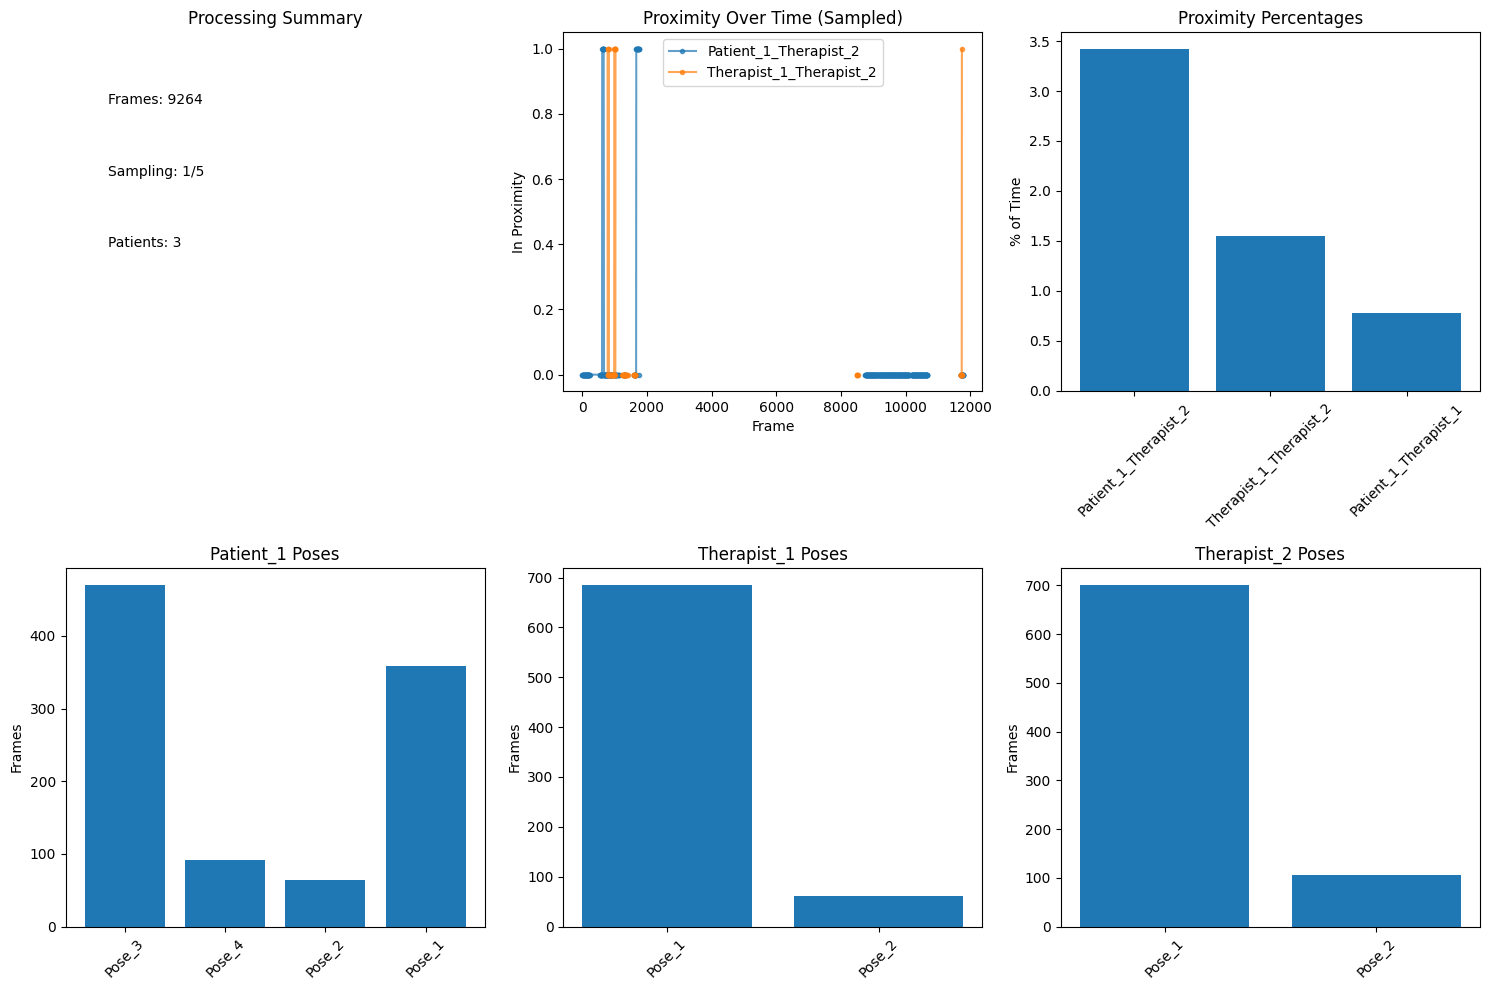

OPTIMIZED POSE ANALYSIS REPORT

Processing Info:
  Frames analyzed: 9264
  Frame sampling: 1 every 5 frames
  Individuals: 3

Proximity Analysis:
  Patient_1_Therapist_2: 3.4% proximity (22 frames)
  Therapist_1_Therapist_2: 1.6% proximity (10 frames)
  Patient_1_Therapist_1: 0.8% proximity (5 frames)

Pose Classification:
  Patient_1: 4 poses identified (quality: 0.567)
  Therapist_1: 2 poses identified (quality: 0.758)
  Therapist_2: 2 poses identified (quality: 0.684)


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import networkx as nx
from itertools import combinations
from typing import Dict, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

class OptimizedInteractionAnalyzer:
    """CPU-optimized interaction analyzer with batch processing and caching"""
    
    def __init__(self, proximity_threshold: float = 100.0, frame_sampling: int = 1):
        self.proximity_threshold = proximity_threshold
        self.frame_sampling = frame_sampling  # Process every Nth frame
        self.cache = {}  # Cache expensive calculations
        
    def _get_cached_centroids(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Cache centroid calculations to avoid recomputation"""
        cache_key = f"centroids_{len(joint_positions)}"
        
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        print("Computing centroids (cached)...")
        centroids = []
        
        # Vectorized centroid calculation
        for patient in joint_positions['Patient'].unique():
            patient_data = joint_positions[joint_positions['Patient'] == patient]
            
            # Group by frame and calculate centroids in batch
            key_joints = ['Neck', 'MidHip', 'LeftShoulder', 'RightShoulder']
            patient_key = patient_data[patient_data['Joint'].isin(key_joints)]
            
            if not patient_key.empty:
                # Vectorized groupby operation
                frame_centroids = patient_key.groupby('Frame')[['X', 'Y']].mean().reset_index()
                frame_centroids['Patient'] = patient
                centroids.append(frame_centroids)
        
        if centroids:
            result = pd.concat(centroids, ignore_index=True)
            self.cache[cache_key] = result
            return result
        
        return pd.DataFrame()
    
    def calculate_proximity_features_optimized(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Optimized proximity calculation using vectorized operations"""
        print("Calculating proximity features (optimized)...")
        
        # Sample frames to reduce computation
        frames = sorted(joint_positions['Frame'].unique())[::self.frame_sampling]
        sampled_data = joint_positions[joint_positions['Frame'].isin(frames)]
        
        centroids_df = self._get_cached_centroids(sampled_data)
        
        if centroids_df.empty:
            return pd.DataFrame()
        
        proximity_features = []
        patients = centroids_df['Patient'].unique()
        patient_pairs = list(combinations(patients, 2))
        
        # Vectorized distance calculation per frame
        for frame in frames:
            frame_centroids = centroids_df[centroids_df['Frame'] == frame]
            
            if len(frame_centroids) < 2:
                continue
                
            frame_features = {'Frame': frame}
            
            # Calculate all pairwise distances for this frame
            for p1, p2 in patient_pairs:
                p1_data = frame_centroids[frame_centroids['Patient'] == p1]
                p2_data = frame_centroids[frame_centroids['Patient'] == p2]
                
                if not p1_data.empty and not p2_data.empty:
                    # Vectorized distance calculation
                    dist = np.sqrt((p1_data['X'].iloc[0] - p2_data['X'].iloc[0])**2 + 
                                  (p1_data['Y'].iloc[0] - p2_data['Y'].iloc[0])**2)
                    
                    frame_features[f'distance_{p1}_{p2}'] = dist
                    frame_features[f'proximity_{p1}_{p2}'] = 1 if dist < self.proximity_threshold else 0
                    
                    # Quick spatial relationship
                    dx = p2_data['X'].iloc[0] - p1_data['X'].iloc[0]
                    dy = p2_data['Y'].iloc[0] - p1_data['Y'].iloc[0]
                    
                    if abs(dx) > abs(dy):
                        relation = 'side' if dx > 0 else 'opposite'
                    else:
                        relation = 'front' if dy > 0 else 'back'
                    
                    frame_features[f'relation_{p1}_{p2}'] = relation
            
            proximity_features.append(frame_features)
        
        return pd.DataFrame(proximity_features)
    
    def extract_lightweight_pose_features(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Extract only essential pose features to reduce computation"""
        print("Extracting lightweight pose features...")
        
        # Sample frames
        frames = sorted(joint_positions['Frame'].unique())[::self.frame_sampling]
        sampled_data = joint_positions[joint_positions['Frame'].isin(frames)]
        
        features = []
        essential_joints = ['Nose', 'Neck', 'LeftWrist', 'RightWrist', 'LeftShoulder', 'RightShoulder']
        
        for patient in sampled_data['Patient'].unique():
            patient_data = sampled_data[sampled_data['Patient'] == patient]
            patient_essential = patient_data[patient_data['Joint'].isin(essential_joints)]
            
            # Create pivot table for essential joints only
            pivot_x = patient_essential.pivot_table(index='Frame', columns='Joint', values='X')
            pivot_y = patient_essential.pivot_table(index='Frame', columns='Joint', values='Y')
            
            # Combine and add patient identifier
            patient_features = pd.concat([
                pivot_x.add_prefix('X_'),
                pivot_y.add_prefix('Y_')
            ], axis=1)
            
            patient_features['Patient'] = patient
            features.append(patient_features.reset_index())
        
        if features:
            return pd.concat(features, ignore_index=True)
        return pd.DataFrame()

class FastClusteringAnalyzer:
    """Optimized clustering with reduced feature set and smart k-selection"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=2)
    
    def fast_clustering(self, features: pd.DataFrame, max_k: int = 4) -> Dict:
        """Fast clustering with limited k-range and early stopping"""
        results = {}
        
        for patient in features['Patient'].unique():
            print(f"Clustering {patient}...")
            
            patient_features = features[features['Patient'] == patient].copy()
            numeric_features = patient_features.select_dtypes(include=[np.number])
            numeric_features = numeric_features.dropna(axis=1, how='all')
            
            if numeric_features.shape[0] < 10 or numeric_features.shape[1] < 2:
                continue
            
            # Fill missing values with median (faster than interpolation)
            numeric_features = numeric_features.fillna(numeric_features.median())
            
            # Reduce dimensionality first if too many features
            if numeric_features.shape[1] > 10:
                pca_temp = PCA(n_components=10)
                numeric_features = pd.DataFrame(pca_temp.fit_transform(numeric_features))
            
            X_scaled = self.scaler.fit_transform(numeric_features)
            
            # Smart k-selection: start from k=3, stop early if silhouette drops
            best_k = 3
            best_score = -1
            
            for k in range(2, min(max_k + 1, len(numeric_features) // 3)):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=3)  # Reduced n_init
                labels = kmeans.fit_predict(X_scaled)
                
                try:
                    score = silhouette_score(X_scaled, labels)
                    if score > best_score:
                        best_score = score
                        best_k = k
                    elif score < best_score - 0.1:  # Early stopping if score drops significantly
                        break
                except:
                    continue
            
            # Final clustering with best k
            final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=3)
            final_labels = final_kmeans.fit_predict(X_scaled)
            
            # Simple pose labeling
            pose_labels = {}
            for i in range(best_k):
                pose_labels[i] = f'Pose_{i+1}'
            
            results[patient] = {
                'labels': final_labels,
                'pose_labels': pose_labels,
                'k': best_k,
                'silhouette': best_score,
                'features': numeric_features
            }
        
        return results

class OptimizedAnalyzer:
    """Main optimized analyzer with memory management and batch processing"""
    
    def __init__(self, frame_sampling: int = 5, max_frames: Optional[int] = None):
        """
        Args:
            frame_sampling: Process every Nth frame (5 = every 5th frame)
            max_frames: Maximum number of frames to process (None = all)
        """
        self.frame_sampling = frame_sampling
        self.max_frames = max_frames
        self.interaction_analyzer = OptimizedInteractionAnalyzer(frame_sampling=frame_sampling)
        self.clustering_analyzer = FastClusteringAnalyzer()
        self.results = {}
    
    def run_optimized_analysis(self, joint_positions: pd.DataFrame) -> Dict:
        """Run memory and CPU optimized analysis"""
        print(f"Starting optimized analysis with frame sampling: {self.frame_sampling}")
        
        # Clean data first
        joint_positions = self._clean_data_efficient(joint_positions)
        
        # Limit frames if specified
        if self.max_frames:
            frames = sorted(joint_positions['Frame'].unique())[:self.max_frames]
            joint_positions = joint_positions[joint_positions['Frame'].isin(frames)]
        
        print(f"Processing {joint_positions['Frame'].nunique()} frames for {joint_positions['Patient'].nunique()} individuals")
        
        # 1. Fast proximity analysis
        proximity_features = self.interaction_analyzer.calculate_proximity_features_optimized(joint_positions)
        
        # 2. Lightweight pose features
        pose_features = self.interaction_analyzer.extract_lightweight_pose_features(joint_positions)
        
        # 3. Fast clustering
        clustering_results = {}
        if not pose_features.empty:
            clustering_results = self.clustering_analyzer.fast_clustering(pose_features)
        
        # 4. Simple temporal analysis (avoid complex network analysis)
        temporal_summary = self._quick_temporal_analysis(proximity_features)
        
        # Store results
        self.results = {
            'proximity_features': proximity_features,
            'pose_features': pose_features,
            'clustering_results': clustering_results,
            'temporal_summary': temporal_summary,
            'processing_info': {
                'frames_processed': joint_positions['Frame'].nunique(),
                'frame_sampling': self.frame_sampling,
                'total_patients': joint_positions['Patient'].nunique()
            }
        }
        
        print("Optimized analysis complete!")
        return self.results
    
    def _clean_data_efficient(self, df: pd.DataFrame) -> pd.DataFrame:
        """Memory-efficient data cleaning"""
        # Remove unnamed columns and background in one operation
        df = df.drop([col for col in df.columns if 'Unnamed' in col], axis=1, errors='ignore')
        df = df[df['Joint'] != 'Background'].copy()
        
        # Efficient type conversion
        df['Frame'] = df['Frame'].astype(int)
        df[['X', 'Y']] = df[['X', 'Y']].apply(pd.to_numeric, errors='coerce')
        
        # Remove invalid coordinates
        df = df.dropna(subset=['X', 'Y'])
        
        return df
    
    def _quick_temporal_analysis(self, proximity_df: pd.DataFrame) -> Dict:
        """Simplified temporal analysis to reduce computation"""
        if proximity_df.empty:
            return {}
        
        summary = {}
        proximity_cols = [col for col in proximity_df.columns if col.startswith('proximity_')]
        
        for col in proximity_cols:
            pair = col.replace('proximity_', '')
            proximity_frames = proximity_df[proximity_df[col] == 1]
            
            if not proximity_frames.empty:
                summary[pair] = {
                    'total_proximity_frames': len(proximity_frames),
                    'proximity_percentage': len(proximity_frames) / len(proximity_df) * 100,
                    'first_interaction': proximity_frames['Frame'].min(),
                    'last_interaction': proximity_frames['Frame'].max()
                }
        
        return summary
    
    def create_summary_visualization(self):
        """Create lightweight visualizations"""
        if not self.results:
            print("No results to visualize")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # 1. Processing info
        axes[0, 0].text(0.1, 0.8, f"Frames: {self.results['processing_info']['frames_processed']}", transform=axes[0, 0].transAxes)
        axes[0, 0].text(0.1, 0.6, f"Sampling: 1/{self.results['processing_info']['frame_sampling']}", transform=axes[0, 0].transAxes)
        axes[0, 0].text(0.1, 0.4, f"Patients: {self.results['processing_info']['total_patients']}", transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Processing Summary')
        axes[0, 0].axis('off')
        
        # 2. Proximity timeline (sampled)
        proximity_df = self.results['proximity_features']
        if not proximity_df.empty:
            proximity_cols = [col for col in proximity_df.columns if col.startswith('proximity_')]
            for col in proximity_cols[:2]:  # Show max 2 pairs
                pair = col.replace('proximity_', '')
                axes[0, 1].plot(proximity_df['Frame'], proximity_df[col], 
                               label=pair, marker='o', markersize=3, alpha=0.7)
            axes[0, 1].set_title('Proximity Over Time (Sampled)')
            axes[0, 1].set_xlabel('Frame')
            axes[0, 1].set_ylabel('In Proximity')
            axes[0, 1].legend()
        
        # 3. Temporal summary
        temporal_summary = self.results['temporal_summary']
        if temporal_summary:
            pairs = list(temporal_summary.keys())
            percentages = [data['proximity_percentage'] for data in temporal_summary.values()]
            
            axes[0, 2].bar(pairs, percentages)
            axes[0, 2].set_title('Proximity Percentages')
            axes[0, 2].set_ylabel('% of Time')
            axes[0, 2].tick_params(axis='x', rotation=45)
        
        # 4-6. Clustering results
        clustering_results = self.results['clustering_results']
        plot_idx = 0
        for patient, cluster_data in clustering_results.items():
            if plot_idx >= 3:
                break
            
            ax = axes[1, plot_idx]
            
            # Simple cluster visualization
            labels = cluster_data['labels']
            pose_counts = {}
            for label in labels:
                pose = cluster_data['pose_labels'][label]
                pose_counts[pose] = pose_counts.get(pose, 0) + 1
            
            ax.bar(pose_counts.keys(), pose_counts.values())
            ax.set_title(f'{patient} Poses')
            ax.set_ylabel('Frames')
            ax.tick_params(axis='x', rotation=45)
            
            plot_idx += 1
        
        plt.tight_layout()
        plt.show()
    
    def generate_quick_report(self) -> str:
        """Generate lightweight analysis report"""
        if not self.results:
            return "No results available"
        
        report = []
        report.append("OPTIMIZED POSE ANALYSIS REPORT")
        report.append("=" * 50)
        
        info = self.results['processing_info']
        report.append(f"\nProcessing Info:")
        report.append(f"  Frames analyzed: {info['frames_processed']}")
        report.append(f"  Frame sampling: 1 every {info['frame_sampling']} frames")
        report.append(f"  Individuals: {info['total_patients']}")
        
        temporal_summary = self.results['temporal_summary']
        if temporal_summary:
            report.append(f"\nProximity Analysis:")
            for pair, data in temporal_summary.items():
                report.append(f"  {pair}: {data['proximity_percentage']:.1f}% proximity ({data['total_proximity_frames']} frames)")
        
        clustering_results = self.results['clustering_results']
        if clustering_results:
            report.append(f"\nPose Classification:")
            for patient, data in clustering_results.items():
                report.append(f"  {patient}: {data['k']} poses identified (quality: {data['silhouette']:.3f})")
        
        return "\n".join(report)

# Simplified usage function
def run_fast_analysis(joint_positions: pd.DataFrame, 
                     frame_sampling: int = 10, 
                     max_frames: Optional[int] = 1000):
    """
    Run CPU-optimized analysis
    
    Args:
        joint_positions: Your dataframe
        frame_sampling: Process every Nth frame (10 = every 10th frame)
        max_frames: Maximum frames to process (1000 = first 1000 frames)
    """
    
    analyzer = OptimizedAnalyzer(frame_sampling=frame_sampling, max_frames=max_frames)
    
    results = analyzer.run_optimized_analysis(joint_positions)
    
    # Quick visualization
    analyzer.create_summary_visualization()
    
    # Quick report
    report = analyzer.generate_quick_report()
    print(report)
    
    return results, analyzer

# Example usage
if __name__ == "__main__":
    print("CPU-Optimized Pose Analysis Ready!")
    print("\nFor fast analysis with your large dataset:")
    results, analyzer = run_fast_analysis(joint_positions, frame_sampling=5, max_frames=10000)


## Gaze Analysis from FacesDir JSON files

In [20]:
#!/usr/bin/env python3
import os
import tarfile
import re
import json
import shutil
from pathlib import Path

# === CONFIGURE THIS ===
BASE_FACES_DIR = "/home/liubov/Desktop/BNF/work/8-5-2024_#18_INDIVIDUAL_[12]/FacesDir"
MERGED_DIR = Path(BASE_FACES_DIR) / "Merged"
# ======================


def clean_up(directory: Path):
    """Recursively removes a directory and its contents."""
    if directory.is_dir():
        try:
            shutil.rmtree(directory)
            print(f"    [cleanup] Removed directory: {directory}")
        except OSError as e:
            print(f"    [cleanup] Error removing directory {directory}: {e}")


def process_chunk_dir(chunk_dir: Path):
    chunk_name = chunk_dir.name.split("chunk_")[-1]  # e.g. "00_00000-00120s"
    archives = [p for p in chunk_dir.iterdir() if p.is_file() and p.name.endswith(".tar.gz")]
    if not archives:
        print(f"[{chunk_dir.name}] no .tar.gz archives found, skipping.")
        return

    for archive in sorted(archives):
        m = re.search(r"(\d+)\.tar\.gz$", archive.name)
        if not m:
            print(f"  [skip] archive name doesn't match pattern: {archive.name}")
            continue
        archive_id = m.group(1)
        extract_dir = chunk_dir / f"unpacked_{archive_id}"
        extract_dir.mkdir(parents=True, exist_ok=True)

        # Extract archive
        with tarfile.open(archive, "r:gz") as tar:
            tar.extractall(path=extract_dir)

        # Flatten + rename JSON files into unpacked_X/
        renamed_count = 0
        for root, dirs, files in os.walk(extract_dir):
            root_path = Path(root)
            for fname in files:
                if not fname.lower().endswith(".json"):
                    continue
                match = re.search(r"(\d+)\.json$", fname)
                if not match:
                    continue
                y_number = match.group(1)
                # Normalize → integer → zero-padded to 6 digits
                y_number = f"{int(y_number):06d}"

                new_name = f"id_{archive_id}_{chunk_name}_{y_number}.json"
                old_path = root_path / fname
                new_path = extract_dir / new_name  # flatten into unpacked_X

                if new_path.exists():
                    new_path.unlink()

                old_path.rename(new_path)
                renamed_count += 1

        print(f"[{chunk_dir.name}] {archive.name} -> renamed {renamed_count} json file(s).")

        # === Merge step ===
        merge_jsons(chunk_dir, archive_id, chunk_name, extract_dir)
        
        # === Cleanup step ===
        clean_up(extract_dir)


def merge_jsons(chunk_dir: Path, archive_id: str, chunk_name: str, extract_dir: Path):
    """Merge all JSON files from unpacked_X root into one JSON array."""
    merged_chunk_dir = MERGED_DIR / chunk_dir.name
    merged_chunk_dir.mkdir(parents=True, exist_ok=True)

    merged_file = merged_chunk_dir / f"id_{archive_id}_{chunk_name}.json"

    merged_data = []
    for fname in sorted(extract_dir.iterdir()):
        if fname.is_file() and fname.suffix.lower() == ".json":
            try:
                with open(fname, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    merged_data.append(data)
            except Exception as e:
                print(f"    [warn] Failed to read {fname}: {e}")

    with open(merged_file, "w", encoding="utf-8") as f:
        json.dump(merged_data, f, ensure_ascii=False, indent=2)

    print(f"    [merge] Created {merged_file} with {len(merged_data)} items.")


def main():
    base = Path(BASE_FACES_DIR)
    if not base.exists():
        print(f"Base directory does not exist: {base}")
        return

    chunk_dirs = sorted([p for p in base.iterdir() if p.is_dir() and p.name.startswith("chunk_")])
    if not chunk_dirs:
        print("No chunk_* directories found in", base)
        return

    for chunk_dir in chunk_dirs:
        process_chunk_dir(chunk_dir)

    print(" Done: All chunk_* folders processed, merged JSONs saved into 'Merged/'.")


if __name__ == "__main__":
    main()

[chunk_00_00000-00120s] 1.tar.gz -> renamed 1800 json file(s).
    [merge] Created /home/liubov/Desktop/BNF/work/8-5-2024_#18_INDIVIDUAL_[12]/FacesDir/Merged/chunk_00_00000-00120s/id_1_00_00000-00120s.json with 1800 items.
    [cleanup] Removed directory: /home/liubov/Desktop/BNF/work/8-5-2024_#18_INDIVIDUAL_[12]/FacesDir/chunk_00_00000-00120s/unpacked_1
[chunk_00_00000-00120s] 2.tar.gz -> renamed 1800 json file(s).
    [merge] Created /home/liubov/Desktop/BNF/work/8-5-2024_#18_INDIVIDUAL_[12]/FacesDir/Merged/chunk_00_00000-00120s/id_2_00_00000-00120s.json with 1800 items.
    [cleanup] Removed directory: /home/liubov/Desktop/BNF/work/8-5-2024_#18_INDIVIDUAL_[12]/FacesDir/chunk_00_00000-00120s/unpacked_2
[chunk_00_00000-00120s] 3.tar.gz -> renamed 1800 json file(s).
    [merge] Created /home/liubov/Desktop/BNF/work/8-5-2024_#18_INDIVIDUAL_[12]/FacesDir/Merged/chunk_00_00000-00120s/id_3_00_00000-00120s.json with 1800 items.
    [cleanup] Removed directory: /home/liubov/Desktop/BNF/work/